In [0]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
import tensorflow
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.layers import Dense, Activation,Flatten
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()

#set random seed for the session and also for tensorflow that runs in background for keras
# set_random_seed(123)
tensorflow.random.set_seed(123)

In [3]:
train= pd.read_csv("/content/drive/My Drive/Colab Notebooks/lab2/train.tsv", sep="\t")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/lab2/test.tsv", sep="\t")

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
train['Phrase'][100]

'would have a hard time sitting through this one .'

In [0]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [6]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [7]:
#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [00:27<00:00, 2406.61it/s]

156060
66292


In [8]:
train_sentences[100]

['would', 'have', 'a', 'hard', 'time', 'sitting', 'through', 'this', 'one']

In [0]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [10]:
y_target

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [0]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [12]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)


100%|██████████| 124848/124848 [00:00<00:00, 498283.83it/s]

13739
48


In [13]:
for x in tqdm(X_train[1:10]):
  print(x)

100%|██████████| 9/9 [00:00<00:00, 7633.72it/s]

['a', 'remarkable', 'movie', 'with', 'an', 'unsatisfying', 'ending', 'which', 'is', 'just', 'the', 'point']
['emphasizing', 'the', 'disappointingly', 'generic', 'nature', 'of', 'the', 'entire', 'effort']
['s', 'a', 'certain', 'robustness', 'to', 'this', 'engaging', 'mix', 'of', 'love', 'and', 'bloodletting']
['of', 'lively', 'song', 'for', 'deft', 'punctuation']
['it', 'minute']
['too', 'impressed', 'with', 'it', 'own', 'solemn', 'insight']
['confession', 'is', 'n', 't', 'always', 'coherent']
['this', 'little', 'known', 'story', 'of', 'native', 'american', 'and']
['evokes', 'the', 'th', 'century', 'with', 'a', 'subtlety', 'that', 'is', 'an', 'object', 'lesson', 'in', 'period', 'filmmaking']


In [14]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [15]:
#Model using Keras CNN
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(Conv1D(128,5,activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128,5,activation='relu'))
#model.add(MaxPooling1D(35))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4121700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 128)           192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 128)            82048     
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [16]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=4, batch_size=256, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/4
124848/124848 [==============================] - 210s 2ms/step - loss: 1.2095 - accuracy: 0.5346 - val_loss: 1.1472 - val_accuracy: 0.5600
Epoch 2/4
124848/124848 [==============================] - 208s 2ms/step - loss: 1.1099 - accuracy: 0.5800 - val_loss: 1.1204 - val_accuracy: 0.5691
Epoch 3/4
124848/124848 [==============================] - 205s 2ms/step - loss: 1.0680 - accuracy: 0.5956 - val_loss: 1.1117 - val_accuracy: 0.5769
Epoch 4/4
124848/124848 [==============================] - 206s 2ms/step - loss: 1.0428 - accuracy: 0.6038 - val_loss: 1.1171 - val_accuracy: 0.5780


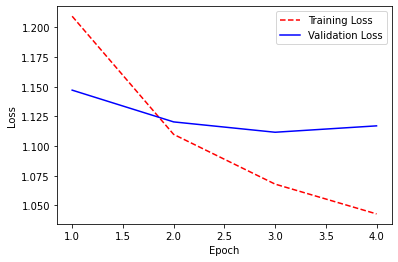

In [17]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()